In [1]:
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
import cv2
import matplotlib.pyplot as plt
import numpy as np

""" Functions for class """

def colour2bw(image):
    grey_horse = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (_, white_horse) = cv2.threshold(grey_horse, 10, 255, cv2.THRESH_BINARY)
    return white_horse

def image2pixels(bw_image):    
    # Initialise arrays to store positions of each pixel
    x_pixels = np.zeros(len(bw_image.flatten()))
    y_pixels = np.zeros(len(bw_image.flatten()))
    # Store position of each pixel
    count = 0
    for row in range(bw_image.shape[0]):
        for column in range(bw_image.shape[1]):
            if bw_image[row,column] != 0:
                x_pixels[count] = column
                y_pixels[count] = -row
            count += 1
    # Remove datapoints where there are no pixels
    x_pixels = x_pixels[x_pixels != 0]
    y_pixels = y_pixels[y_pixels != 0]
    return x_pixels, y_pixels

""" Plotting functions """

def plot_image(ax, image):
    ax.imshow(image, cmap='gray', aspect='auto')
    return ax    

def plot_pixels(ax, pixels):
    ax.scatter(pixels[0], pixels[1], s=0.5)
    return ax

def plot_labelled_pixels(ax, pixels, labels):
    ax.scatter(pixels[0], pixels[1], c=labels, s=0.5, cmap='viridis')
    return ax

def plot_ellipses(ax, animal):
    ax.scatter(animal.pixels[0], animal.pixels[1], c=animal.labels, s=0.5, cmap='viridis')
    # Draw the Ellipse
    for i in range(len(animal.ellipse.positions)):
        nsig = 1.7
        ax.add_patch(Ellipse(animal.ellipse.positions[i], 
                            nsig * animal.ellipse.widths[i], 
                            nsig * animal.ellipse.heights[i],
                            animal.ellipse.angles[i], 
                            color='k', 
                            fill=False))
    return ax
    
def plot_animals(*args):
    amount = len(args)
    _, ax = plt.subplots(amount, 4, figsize=(20,18))
    for i, animal in enumerate(args):
        ax[i,0] = plot_image(ax[i,0], animal.bw)
        ax[i,1] = plot_pixels(ax[i,1], animal.pixels)
        ax[i,2] = plot_labelled_pixels(ax[i,2], animal.pixels, animal.labels)
        ax[i,3] = plot_ellipses(ax[i,3], animal)
    plt.show()

""" Animals class """

class Draw_my_horsey:
    
    def __init__(self, path):
        self.image = cv2.imread(path)
        self.bw = colour2bw(self.image)
        self.pixels = image2pixels(self.bw)
    
    def do_gmm(self, ncomponents):
        self.ncomponents = ncomponents
        self.gmm = GMM(n_components=self.ncomponents, random_state=0)
        self.xy = np.transpose(np.array(self.pixels))
        self.labels = self.gmm.fit(self.xy).predict(self.xy)

    def ellipse_data(self):
        # Initialise lists for storing data
        positions = []
        widths = []
        heights = []
        angles = []
        # Get ellipse data
        for position, covariance in zip(self.gmm.means_, self.gmm.covariances_):
            positions.append(position)
            if covariance.shape == (2, 2):
                U, s, _ = np.linalg.svd(covariance)
                angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
                width, height = 2 * np.sqrt(s)
            else:
                angle = 0
                width, height = 2 * np.sqrt(covariance)
            widths.append(width)
            heights.append(height)
            angles.append(angle)
        # Create ellipse attribute and save sub-attributes
        self.ellipse = type("ellipse_data",(),{})()
        self.ellipse.positions = positions
        self.ellipse.widths = widths
        self.ellipse.heights = heights
        self.ellipse.angles = angles
    
    def full_shebang(self, ncomponents):
        self.do_gmm(ncomponents)
        self.ellipse_data()

## Display images and pixel images

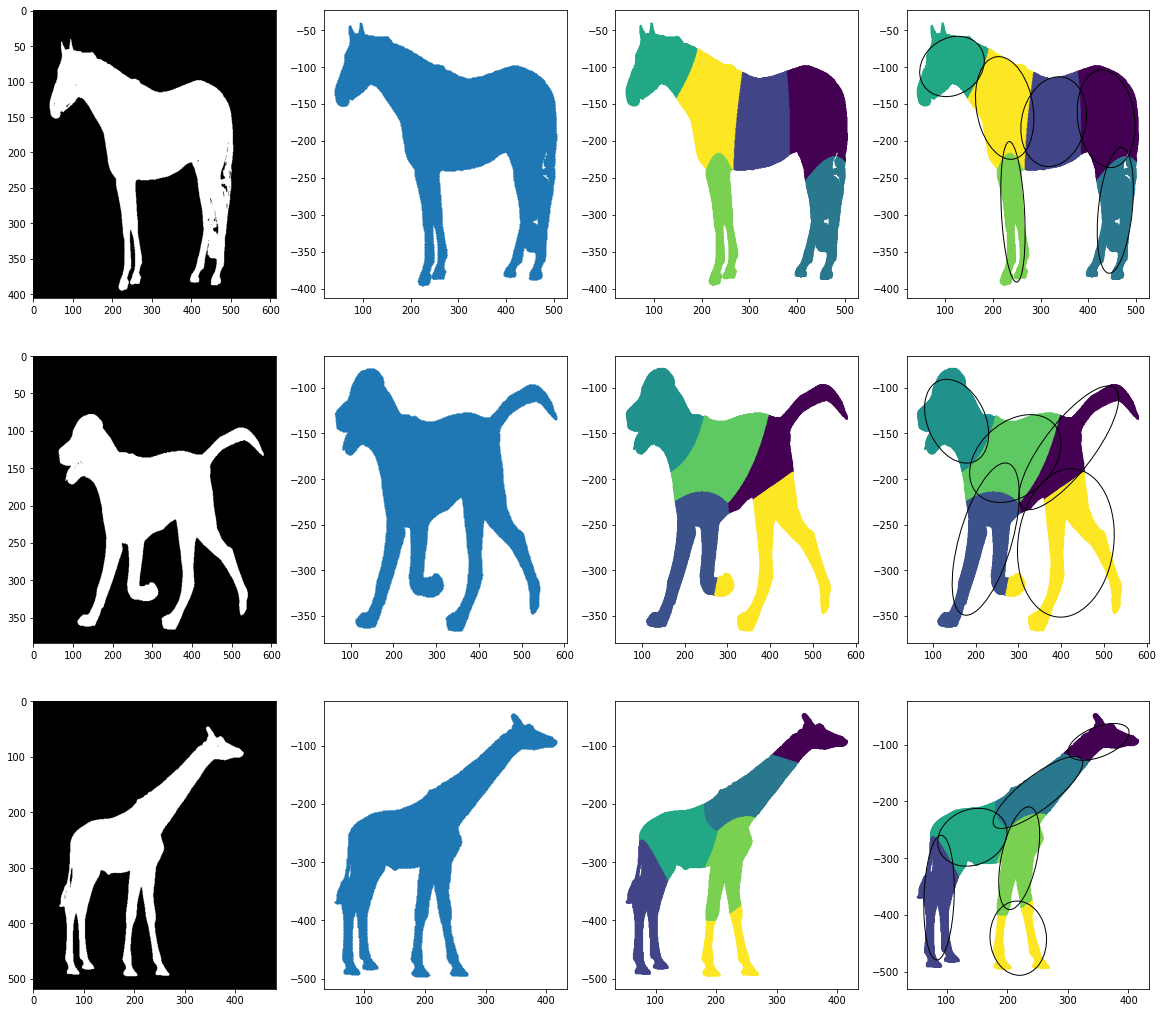

In [2]:
# Initialise objects
horse = Draw_my_horsey('Images/horse.png')
poochie = Draw_my_horsey('Images/DogNoBg.png')
giraffe = Draw_my_horsey('Images/GiraffeNoBG.png')

# Do the gmm
horse.do_gmm(6)
poochie.do_gmm(5)
giraffe.do_gmm(6)

# Get the ellipse data
horse.ellipse_data()
poochie.ellipse_data()
giraffe.ellipse_data()

# Plot
plot_animals(horse, poochie, giraffe)